In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.auto import tqdm

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

from IPython.display import display, HTML

from nltk.tokenize import word_tokenize

import gc

# 表示用の設定を変更します
%matplotlib inline
pd.options.display.max_rows = 100
pd.options.display.max_columns = 100
pd.options.display.width = 130

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


# matplotlib.rc('xtick', labelsize=18) 
# matplotlib.rc('ytick', labelsize=18) 

import matplotlib.pylab as pylab
params = {'legend.fontsize': 20,
          'figure.figsize': (15, 5),
         'axes.labelsize':'x-large',
         'axes.titlesize': 22,
         'xtick.labelsize': 'xx-large',
         'ytick.labelsize':18}
pylab.rcParams.update(params)

plt.rcParams["xtick.labelsize"] = 20

In [2]:
from IPython.display import display_html
from itertools import chain,cycle

from IPython.display import display, HTML

def display_side_by_side(*args,titles=cycle([''])):
    html_str=''
    for df,title in zip(args, chain(titles,cycle(['</br>'])) ):
        html_str+='<th style="text-align:center"><td style="vertical-align:top">'
        html_str+=f'<h4>{title}</h4>'
        html_str+=df.to_html().replace('table','table style="display:inline"')
        html_str+='</td></th>'
    display_html(html_str,raw=True)

In [3]:
meta = pd.read_csv("./dataset/metadata.txt", delimiter="\t", names=["user_id", "product_id", "rating", "label", "date"])
review = pd.read_csv("./dataset/reviewContent.txt", delimiter="\t", names=["user_id", "product_id", "date", "review"])

meta["date"] = pd.DatetimeIndex(meta["date"])
review["date"] = pd.DatetimeIndex(review["date"])

total = meta.merge(review, how="inner", on=["user_id", "product_id", "date"])

total.head(2)

,user_id,product_id,rating,label,date,review
0,923,0,3.0,-1,2014-12-08,The food at snack is a selection of popular Gr...
1,924,0,3.0,-1,2013-05-16,This little place in Soho is wonderful. I had ...


In [4]:
total.shape

(358957, 6)

## Label Distribution

<Figure size 360x360 with 0 Axes>

<AxesSubplot:xlabel='label', ylabel='label'>

Text(0.5, 1.0, 'Distribution of target')

([<matplotlib.axis.XTick at 0x23e00c3cb38>,
 [Text(0, 0, 'fake'), Text(1, 0, 'real')])

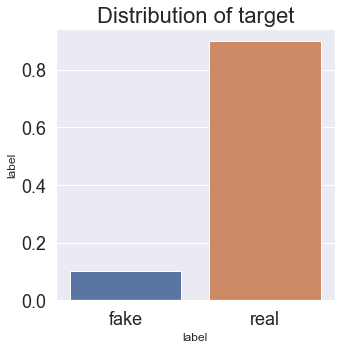

In [5]:
plt.figure(figsize=(5,5))

sns.set_theme()

sns.barplot(x="label", y="label", data=meta, estimator=lambda x: len(x) / len(meta))

plt.title("Distribution of target", fontsize=22)

plt.xticks([0,1], ["fake", "real"])
plt.xlabel("label", fontsize=20)
plt.ylabel("Percentage", fontsize=20)

plt.tick_params(axis='both', which='major', labelsize=18)


Unbalanced target.

Need more metrics such as precision, recall, and F1 score instead of only accuracy if we model data with unbalanced distributions.

## Number of words

In [23]:
total['num_words'] = total['review'].str.split().str.len()

total.head(1)

,user_id,product_id,rating,label,date,review,volatility_3,volatility_7,volatility_14,MA_gap_1month,MA_gap_2month,tokens,fp_pronouns_count,num_unique_words,num_words
0,923,0,3.0,-1,2014-12-08,The food at snack is a selection of popular Gr...,0.57735,0.377964,0.267261,30.0,30.0,"[The, food, at, snack, is, a, selection, of, p...",0,35,40


<AxesSubplot:xlabel='num_words', ylabel='Density'>

<AxesSubplot:xlabel='num_words', ylabel='Density'>

Text(0.5, 1.0, 'Distribution of numer of words (< 1000) in real and fake reviews')

Text(0.5, 0, 'Density')

Text(0, 0.5, 'Numer of words')

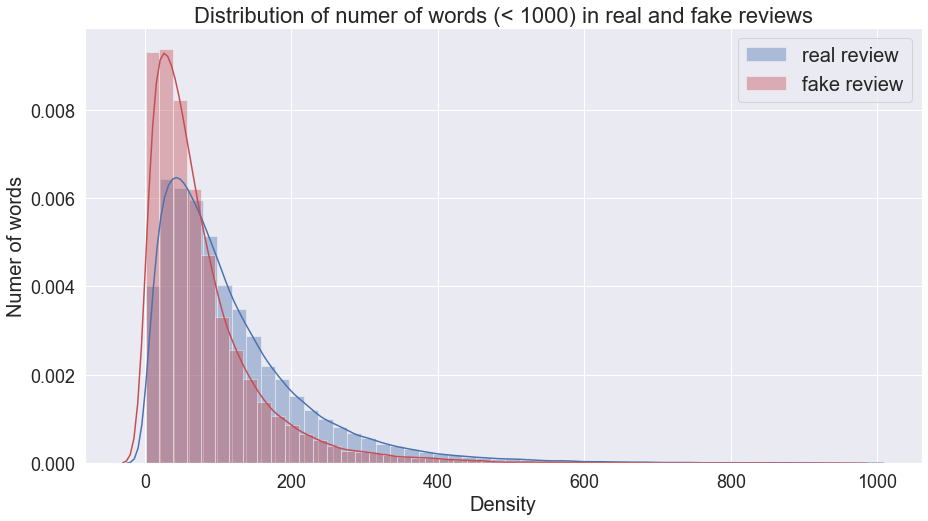

In [301]:
fig, ax = plt.subplots(1, 1, figsize=(15,8))

sns.set_theme()

total_real = total[total["label"]==1]
total_fake = total[total["label"]==-1]

sns.distplot(total_real[total_real["num_words"] < 1000]["num_words"], label="real review", color='#4c72b0')
sns.distplot(total_fake[total_fake["num_words"] < 1000]["num_words"], label="fake review", color='#c44e52')

# sns.displot(data=total[total["num_words"] < 1000], x="num_words", hue="label", kind="kde", legend=True, ax=ax)

# sns.displot(x="num_words", data=total[total["label"]==1])
# sns.displot(x="num_words", data=total[total["label"]==-1])

plt.title("Distribution of numer of words (< 1000) in real and fake reviews", fontsize=22)

plt.legend(fontsize=20)

plt.tick_params(axis='both', which='major', labelsize=18)

plt.xlabel("Density", fontsize=20)
plt.ylabel("Numer of words", fontsize=20)


Two distiburtions look different. Is this noise?

Use Kolmogorov-Smirnov test (KS-Test)

Asumptions
1. The null hypothesis is both samples are randomly drawn from the same (pooled) set of values.
Satisfied.
2. The two samples are mutually independent.
Satisfied.
3. The scale of measurement is at least ordinal.
Satisfied.
4. The test is only exact for continuous variables. It is conservative for discrete variables.
Satisfied.

Null hypothesis: 2 independent samples are drawn from the same continuous distribution.
Alternative hypothesis: Null is not true.

In [6]:
from scipy.stats import ks_2samp

ks_2samp(total_real["num_words"].values, total_fake["num_words"].values, alternative='two-sided')

KstestResult(statistic=0.19956392672164958, pvalue=0.0)

pvalue = 0.0. Reject null hypothesis. We can say that two distributions doesn't come from the same distribution.
Number of words is worth adding to our features.

## Are fake users more likely to post only rating=1.0 and rating =5.0 reviews?

<Figure size 576x360 with 0 Axes>

<AxesSubplot:xlabel='label', ylabel='label'>

([<matplotlib.axis.XTick at 0x1d4c8c17d30>,
 [Text(0, 0, 'fake'), Text(1, 0, 'real')])

Text(0.5, 0, 'label')

Text(0, 0.5, 'Percentage')

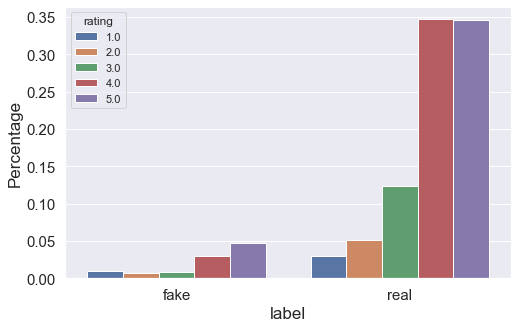

In [290]:
plt.figure(figsize=(8,5))

sns.barplot(x="label", y="label", hue="rating", data=meta, estimator=lambda x: len(x) / len(meta))

plt.xticks([0,1], ["fake", "real"])
plt.xlabel("label", fontsize=17)
plt.ylabel("Percentage", fontsize=17)

plt.tick_params(axis='both', which='major', labelsize=15)

Fake users is slightly more likely to post rating=1 or rating=5 reviews. It is pretty natural because fake users post fake reviews to write very bad reviews for rival companies and very good reviews for their own companies.

Is this noise?

Conduct chis-squared independece test.

Major assumptions (https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3900058/)
1. The levels (or categories) of the variables are mutually exclusive.
Satisfied.
2. The study groups must be independent.
Satisfied.
3. There are 2 variables, and both are measured as categories, usually at the nominal level. However, data may be ordinal data. 
Satified.

Ho:  No relationship exists on the categorical variables  Ha: Ho is not true.

In [51]:
from scipy.stats import chi2_contingency

fake_rating = meta[meta["label"]==-1]["rating"]
real_rating = meta[meta["label"]==1]["rating"]

obs = list()
obs.append(fake_rating.value_counts().tolist()); obs.append(real_rating.value_counts().tolist())

print("Tables: ", obs, "\n")

chi2, p, dof, ex = chi2_contingency(obs)

print("p-value", p)

Tables:  [[17006, 10748, 3566, 3173, 2392], [124502, 124151, 44473, 18383, 10658]] 

p-value 0.0


p-value is 0. Reject Ho. There is some relationship between variables.

Fake accounts are more likely to post rating=1 and rating=5 possibly because they write bad reviews for rival companies and good reviews for their own companies.

## Rating deviation

If there are many bad reviews
 → Desire to make fake reviews with good rating

If there are many good reviews already 
→ No need to make fake review with good rating

Rating deviation = deviation from mean rating of that product

In [273]:
total["mean_rating"] = total.groupby("product_id", as_index=False)[["rating"]].transform("mean")
total["rating_deviation"] = (total["rating"] - total["mean_rating"]) / total["mean_rating"]

total.drop(["mean_rating"], axis=1, inplace=True)

print("NA percentage: ", total["rating_deviation"].isna().sum().sum() / total["rating_deviation"].shape[0])

NA percentage:  0.0


<AxesSubplot:xlabel='rating_deviation', ylabel='Density'>

<AxesSubplot:xlabel='rating_deviation', ylabel='Density'>

Text(0.5, 0, 'Rating deviation')

Text(0, 0.5, 'Density')

Text(0.5, 1.0, 'Distribution of rating deviation in real and fake reviews')

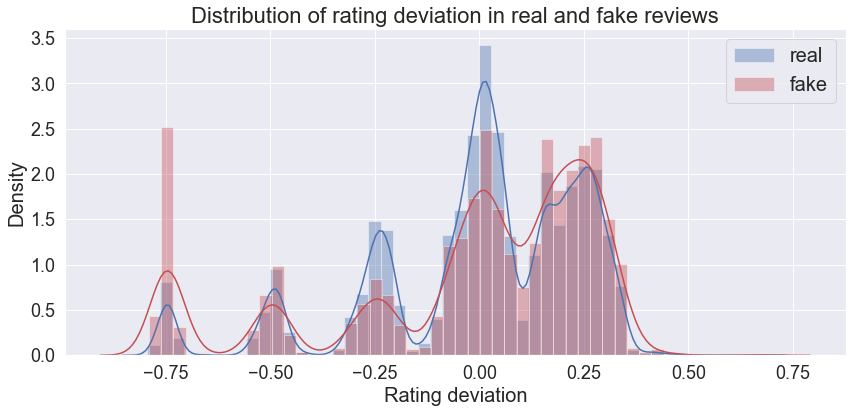

In [293]:
fig, ax = plt.subplots(1, 1, figsize=(14,6))

sns.set_theme()

total_real = total[total["label"]==1]
total_fake = total[total["label"]==-1]

sns.distplot(total_real["rating_deviation"], label="real", color='#4c72b0')
sns.distplot(total_fake["rating_deviation"], label="fake", color='#c44e52')

plt.xlabel("Rating deviation", fontsize=20)
plt.ylabel("Density", fontsize=20)

plt.title("Distribution of rating deviation in real and fake reviews", fontsize=22)

plt.tick_params(axis='both', which='major', labelsize=18)

plt.legend(fontsize=20)


We notice that fake reviews tend to have higher rating devitations while real reviews tend to have lower rating deviation especially from -0.25 to 0.00.

## Number of reviews per product

People want fake reviews because they have a fewer number of reviews meaning that their review has uncertainty?

In [21]:
from statistics import mean

real_count = meta[meta["label"]==1].groupby("product_id")["rating"].count()
fake_count = meta[meta["label"]==-1].groupby("product_id")["rating"].count()
# mix_count = meta[(meta["label"]==1) & (meta[meta["label"]==-1])].groupby("product_id")["rating"].count()

print("Mean count of reviews per product that contains REAL review", mean(real_count), "reviews")
print("Mean count of reviews per product that contains FAKE review", mean(fake_count), "reviews")
# print("Mean count of reviews per product that contains FAKE review", mean(mix_count))


Mean count of reviews per product that contains REAL review 349.0433369447454 reviews
Mean count of reviews per product that contains FAKE review 40.35557986870897 reviews


In [18]:
from scipy.stats import mannwhitneyu

mannwhitneyu(real_count, fake_count)

MannwhitneyuResult(statistic=69495.5, pvalue=3.1764589759624608e-211)

P-value = 0. There is difference between mean count values of the product that contains either fake or real reviews.

## Volatility (Burst) features

Volatility - liability to change rapidly

It is suspicious if one restaurant gets two reviews on average in one day, but suddenly started to get twenty reviews in three days.

In [4]:
# def make_volatility(df, product_id):
#     prod = df[df["product_id"] == product_id]
    
#     prod["count"] = 1

#     date_count = prod.groupby("date", as_index=False)["count"].count().sort_values(by="date")
#     date_count["volatility_30"] =  date_count["count"].diff().rolling(30).std()

#     prod = prod.merge(date_count[["date", "volatility_30"]], on="date")

#     return prod

# Volatility of how many ratings posted in specific product by days
def make_volatility(df, product_id):
    prod = df[df["product_id"] == product_id]
    
    prod["count"] = 1

    date_count = prod.groupby("date", as_index=False)["count"].count().sort_values(by="date")
    
    # Resample to have all dates Ex: "2015-01-01" and "2015-05-01" to "2015-01-01" , "2015-01-01" 
    date_count.set_index("date", drop=True, inplace=True)
    date_count = date_count.resample('D', convention='start').asfreq()
    date_count.fillna(0, inplace=True)
    date_count.reset_index(inplace=True)
    
    # One week volatility
    date_count["volatility_7"] =  date_count["count"].diff().rolling(7).std()

    # Two weeks volatility
    date_count["volatility_14"] =  date_count["count"].diff().rolling(14).std()

    # Three days volatility
    date_count["volatility_3"] =  date_count["count"].diff().rolling(3).std()
    
    # Mean average gap (1 month)
    date_count["MA_gap_1month"] = date_count["count"] / (date_count["count"].rolling(30).mean())

    # Mean average gap (1 month)
    date_count["MA_gap_2month"] = date_count["count"] / (date_count["count"].rolling(30).mean())
    
    merge_lst = ["date", "volatility_3", "volatility_7", "volatility_14", "MA_gap_1month", "MA_gap_2month"]

    prod = prod.merge(date_count[merge_lst], on="date")
    
    prod.drop("count", axis=1, inplace=True)

    return prod


In [5]:
temp = []

for product_id in tqdm(meta["product_id"].unique()):
    temp.append(make_volatility(total, product_id))

total = pd.concat(temp)

total.head(3)

  0%|          | 0/923 [00:00<?, ?it/s]

,user_id,product_id,rating,label,date,review,volatility_3,volatility_7,volatility_14,MA_gap_1month,MA_gap_2month
0,923,0,3.0,-1,2014-12-08,The food at snack is a selection of popular Gr...,0.57735,0.377964,0.267261,30.0,30.0
1,924,0,3.0,-1,2013-05-16,This little place in Soho is wonderful. I had ...,0.57735,0.377964,0.267261,15.0,15.0
2,925,0,4.0,-1,2013-07-01,ordered lunch for 15 from Snack last Friday. ...,0.57735,0.377964,0.474631,15.0,15.0


In [116]:
total[total["label"]==1]["volatility_3"].mean()
total[total["label"]==-1]["volatility_3"].mean()

total[total["label"]==1]["volatility_7"].mean()
total[total["label"]==-1]["volatility_7"].mean()

1.2155204158096813

1.2847783964049084

1.1147862019051715

1.1711412132920114

Are they same? Check with mann whiteyu test. (Normality is not satisfied so we don't use two samples t-test).

In [7]:
from scipy.stats import mannwhitneyu

mannwhitneyu(total[total["label"]==1]["volatility_14"].values, total[total["label"]==-1]["volatility_14"].values)
mannwhitneyu(total[total["label"]==1]["volatility_7"].values, total[total["label"]==-1]["volatility_7"].values)
mannwhitneyu(total[total["label"]==1]["volatility_3"].values, total[total["label"]==-1]["volatility_3"].values)

MannwhitneyuResult(statistic=5746094269.0, pvalue=3.0351517983362653e-24)

MannwhitneyuResult(statistic=5752520494.0, pvalue=9.250712837344402e-23)

MannwhitneyuResult(statistic=5770372715.0, pvalue=6.721205649258438e-19)

p-value = 0. There is difference between mean values of volatility of counts.

Fake review has more volatility of count for every single windows
= Gets more number of reviews suddenly within some (window) days


## Ratio of fraud ratings per product

In [52]:
df = meta.copy()

product = pd.read_csv("./dataset/productIdMapping.txt", delimiter="\t", names=["product_name", "product_id"])

df = df.merge(product, how="left", on=["product_id"])

df.loc[df[df["label"]==1].index, "label"] = 0
df.loc[df[df["label"]==-1].index, "label"] = 1

df.groupby(["product_id", "product_name"], as_index=False)["label"].mean().sort_values(by="label", ascending=False).head(5)

del df; gc.collect()

,product_id,product_name,label
571,571,The Wheelhouse Brooklyn,0.654545
340,340,Anthony and Son Panini Shoppe,0.346939
430,430,Take Root,0.320000
148,148,Chopping Block,0.301887
303,303,The Gorbals,0.290323


It's hard to determine which prodct gets more fake reviews.

## Does fake accounts post many reviews compared to real accounts?

Calculate reviews / accounts per fake and real accounts

In [119]:
num_rates_per_real = meta[meta["label"]==1].shape[0] / meta[meta["label"]==1]["user_id"].nunique()
num_rates_per_fake = meta[meta["label"]==-1].shape[0] / meta[meta["label"]==-1]["user_id"].nunique()

print("How many reviews posted per real account: ", num_rates_per_real, "reviews")
print("How many reviews posted per fake account: ", num_rates_per_fake, "reviews")

meta[meta["label"]==1].shape[0]
meta[meta["label"]==-1].shape[0]

How many reviews posted per real account:  2.433542821748523 reviews
How many reviews posted per fake account:  1.294392195395845 reviews


322167

36885

Very clear difference that we don't even need to conduct statistical test.

Count encoding may be good predictor.

## Number of reviews posted by fake accounts in one day

In [15]:
from statistics import mean

fake_count = meta[meta["label"]==-1].groupby(["date", "user_id"], as_index=False)["label"].count()
real_count = meta[meta["label"]==1].groupby(["date", "user_id"], as_index=False)["label"].count()

mean(fake_count["label"])
mean(real_count["label"])

1.1104588150289016

1.1484635676600599

It's about same.

## Does fake users do only fake reviews or mix of fake and real reviews?

In [ ]:
user_label = meta.groupby(["user_id", "label"], as_index=False)["date"].count()

ratio = user_label["user_id"].duplicated().sum() / user_label["user_id"].nunique()
ratio = ratio*100

print("Percentahttp://localhost:8888/notebooks/1kaggle/yelp/eda_model.ipynb#ge of users who post both fake and real reviews are", ratio, "%")

99.59 % of users post either only fake reviews or real reviews but not both.

User_id is the strong predictor. It may be worth to create target mean encoding per user.

## Subjectivity and objectivity of review

1. Check percentage of first person pronoun (Ex: I, my, me, mine)

2. Sentiment score (more emotional or not)
Refer to:
https://t-redactyl.io/blog/2017/04/using-vader-to-handle-sentiment-analysis-with-social-media-text.html

In [8]:
def pronoun_count(x, type):
    if type == "fp":
        lst = [i for i in x if i in ["I", "my", "mine", "we", "our"]]
    elif type == "tp": 
        lst = [i for i in x if i in ["they", "it", "there"]]
    return len(lst)

total["tokens"] = total['review'].apply(word_tokenize)

total["fp_pronouns_count"] = total["tokens"].apply(lambda x: pronoun_count(x, "fp"))
total["fp_pronouns_ratio"] = total["fp_pronouns_count"] / total["num_words"]

KeyError: 'num_words'

In [88]:
total[total["label"] == 1]["fp_pronouns_ratio"].mean()
total[total["label"] == -1]["fp_pronouns_ratio"].mean()


0.04014729390528521

0.03769082036560625

In [117]:
from scipy.stats import mannwhitneyu

mannwhitneyu(total[total["label"]==1]["fp_pronouns_ratio"].values, total[total["label"]==-1]["fp_pronouns_ratio"].values)

MannwhitneyuResult(statistic=5504309126.5, pvalue=3.2668290897584674e-117)

Mean values are different. Maybe, fake reviews have less first person pronoun because they don't have actual experiences.

## Sentiment score of fake and real accounts

In [12]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

test = total[:10000].drop("review", axis=1).copy()

test['sentiment_score'] = test['review'].apply(SentimentIntensityAnalyzer().polarity_scores)
test = pd.concat([test.drop(['sentiment_score'], axis=1), test['sentiment_score'].apply(pd.Series)], axis=1)

test.head(1)

,user_id,product_id,rating,label,date,review,neg,neu,pos,compound
0,923,0,3.0,-1,2014-12-08,The food at snack is a selection of popular Gr...,0.038,0.834,0.128,0.6170
1,924,0,3.0,-1,2013-05-16,This little place in Soho is wonderful. I had ...,0.086,0.784,0.131,0.5783
2,925,0,4.0,-1,2013-07-01,ordered lunch for 15 from Snack last Friday. ...,0.000,0.757,0.243,0.8515
3,926,0,4.0,-1,2011-07-28,This is a beautiful quaint little restaurant o...,0.020,0.731,0.249,0.9785
4,927,0,4.0,-1,2010-11-01,Snack is great place for a casual sit down lu...,0.000,0.780,0.220,0.9756


In [59]:
total[["neg", "neu", "pos", "compound"]] = pickle.load(open("./dataset/sentiment_score.pkl", 'rb'))

<AxesSubplot:xlabel='pos', ylabel='Density'>

<AxesSubplot:xlabel='pos', ylabel='Density'>

Text(0, 0.5, 'Density')

Text(0.5, 0, 'pos')

<AxesSubplot:xlabel='neg', ylabel='Density'>

<AxesSubplot:xlabel='neg', ylabel='Density'>

Text(0, 0.5, 'Density')

Text(0.5, 0, 'neg')

<AxesSubplot:xlabel='neu', ylabel='Density'>

<AxesSubplot:xlabel='neu', ylabel='Density'>

Text(0, 0.5, 'Density')

Text(0.5, 0, 'neu')

<AxesSubplot:xlabel='compound', ylabel='Density'>

<AxesSubplot:xlabel='compound', ylabel='Density'>

Text(0, 0.5, 'Density')

Text(0.5, 0, 'compound')

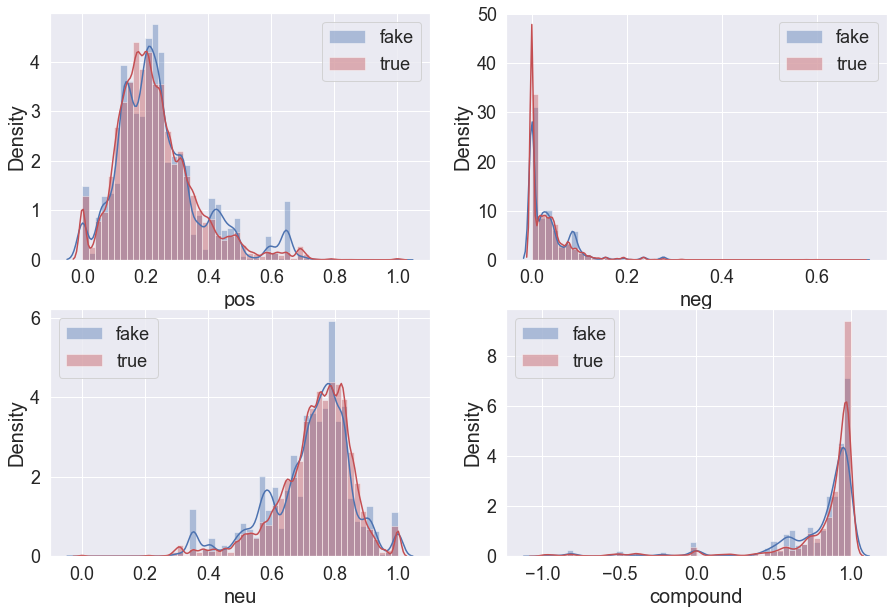

In [103]:
fig, axes = plt.subplots(2, 2, figsize=(15,10))
# , ax2, ax3, ax4
sns.set_theme()

dict = {"pos":axes[0,0], "neg":axes[0,1], "neu":axes[1,0], "compound":axes[1,1]}

for feature, ax in dict.items():
    sns.distplot(total[total["label"]==-1][feature], label="fake", color='#4c72b0', ax=ax)
    sns.distplot(total[total["label"]==1][feature], label="true", color='#c44e52', ax=ax)
    
    ax.set_ylabel("Density", fontsize=20)
    ax.set_xlabel(feature, fontsize=20)
    ax.tick_params(axis='both', which='major', labelsize=18)
    ax.legend(fontsize=18)


In [64]:
from scipy.stats import ks_2samp

ks_2samp(total[total["label"]==-1]["pos"].values, total[total["label"]==1]["pos"].values, alternative='two-sided')
ks_2samp(total[total["label"]==-1]["neu"].values, total[total["label"]==1]["neu"].values, alternative='two-sided')
ks_2samp(total[total["label"]==-1]["compound"].values, total[total["label"]==1]["compound"].values, alternative='two-sided')
ks_2samp(total[total["label"]==-1]["neg"].values, total[total["label"]==1]["neg"].values, alternative='two-sided')

KstestResult(statistic=0.057309408589352795, pvalue=7.258220820686923e-95)

KstestResult(statistic=0.07377990582539218, pvalue=5.101179920915232e-157)

KstestResult(statistic=0.11593993194397878, pvalue=0.0)

KstestResult(statistic=0.062108626191409444, pvalue=2.3367626553286353e-111)

We notice that they are different from ks-test. It looks that those distributions are same, but given that we had more than thirty thousand of data, it wasn't noise.

## Ratio of unique words in review

Domain knowledge:
Fake users use more generic words because they didn't experience it reallly or because they have templates to write reviews?

In [24]:
total["num_unique_words"] = total['review'].apply(lambda x: len(set(str(x).split())))
total["unique_words_ratio"] = total["num_unique_words"] / total["num_words"]

total.drop(["num_unique_words"], axis=1, inplace=True)

total.head(3)

,user_id,product_id,rating,label,date,review,volatility_3,volatility_7,volatility_14,MA_gap_1month,MA_gap_2month,tokens,fp_pronouns_count,num_words,unique_words_ratio
0,923,0,3.0,-1,2014-12-08,The food at snack is a selection of popular Gr...,0.57735,0.377964,0.267261,30.0,30.0,"[The, food, at, snack, is, a, selection, of, p...",0,40,0.875000
1,924,0,3.0,-1,2013-05-16,This little place in Soho is wonderful. I had ...,0.57735,0.377964,0.267261,15.0,15.0,"[This, little, place, in, Soho, is, wonderful,...",1,52,0.826923
2,925,0,4.0,-1,2013-07-01,ordered lunch for 15 from Snack last Friday. ...,0.57735,0.377964,0.474631,15.0,15.0,"[ordered, lunch, for, 15, from, Snack, last, F...",1,32,0.937500


<AxesSubplot:xlabel='unique_words_ratio', ylabel='Density'>

<AxesSubplot:xlabel='unique_words_ratio', ylabel='Density'>

Text(0.5, 0, 'label')

Text(0, 0.5, 'Percentage')

Text(0.5, 1.0, 'Distribution of unique ratio in real and fake reviews')

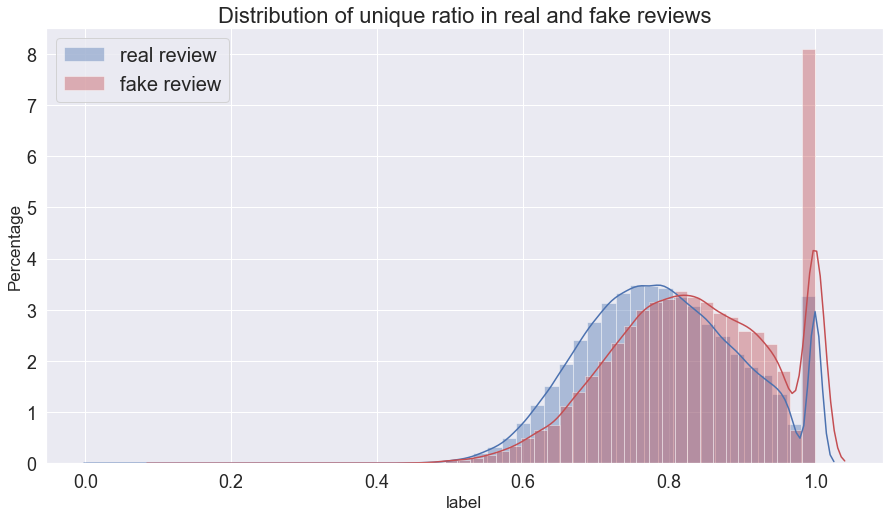

In [27]:
fig, ax = plt.subplots(1, 1, figsize=(15,8))

sns.set_theme()

total_real = total[total["label"]==1]
total_fake = total[total["label"]==-1]

sns.distplot(total_real["unique_words_ratio"], label="real review", color='#4c72b0')
sns.distplot(total_fake["unique_words_ratio"], label="fake review", color='#c44e52')

plt.xlabel("label", fontsize=17)
plt.ylabel("Percentage", fontsize=17)

plt.title("Distribution of unique words ratio in real and fake reviews", fontsize=22)

plt.tick_params(axis='both', which='major', labelsize=18)

plt.legend(fontsize=20)

# sns.displot(data=total[total["num_words"] < 1000], x="num_words", hue="label", kind="kde", legend=True, ax=ax)

# sns.displot(x="num_words", data=total[total["label"]==1])
# sns.displot(x="num_words", data=total[total["label"]==-1])


In [28]:
from scipy.stats import ks_2samp

ks_2samp(total_real["unique_words_ratio"].values, total_fake["unique_words_ratio"].values, alternative='two-sided')

KstestResult(statistic=0.15566381098675547, pvalue=0.0)

Two distributions are different. This may be because fake reviews have less words so that they tend to have more unique words ratio. This doesn't really confirm the idea that fake users use generic more generic words or template.

## Top word ranking by fake and real reviews

In [49]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

stop = stopwords.words('english')

from nltk.tokenize import RegexpTokenizer

tokenizer = RegexpTokenizer(r'\w+')


test = total[:1000].copy()

test["review"] = test["review"].str.lower() 
test["tokens"] = test['review'].apply(tokenizer.tokenize)

test["tokens"] = test["tokens"].apply(lambda x: [i for i in x if i not in stop])

fake = pd.DataFrame(test[test["label"] == -1]["tokens"].tolist()).stack().value_counts().head(30)
real = pd.DataFrame(test[test["label"] == 1]["tokens"].tolist()).stack().value_counts().head(30)


display_side_by_side(pd.DataFrame(fake, columns=["count"]), pd.DataFrame(real, columns=["count"]), titles=['fake review','real review'])

del fake, real; gc.collect()

,count
food,74
great,51
place,48
pizza,47
good,44
service,34
restaurant,31
delicious,29
die,28
french,26


NameError: name 'gc' is not defined

Looks there isn't much difference in order of words.